In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
from keras.models import load_model

In [3]:
data_dir = pathlib.Path("./val-cat-rabbit")
data_dir

WindowsPath('val-cat-rabbit')

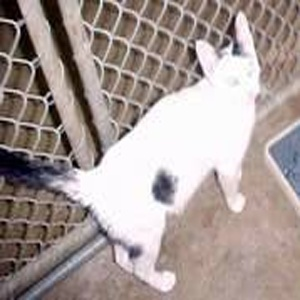

In [6]:
a = list(data_dir.glob('cat/*'))
PIL.Image.open(str(a[10]))

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 414 files belonging to 2 classes.
Using 332 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 414 files belonging to 2 classes.
Using 82 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['cat', 'rabbit']


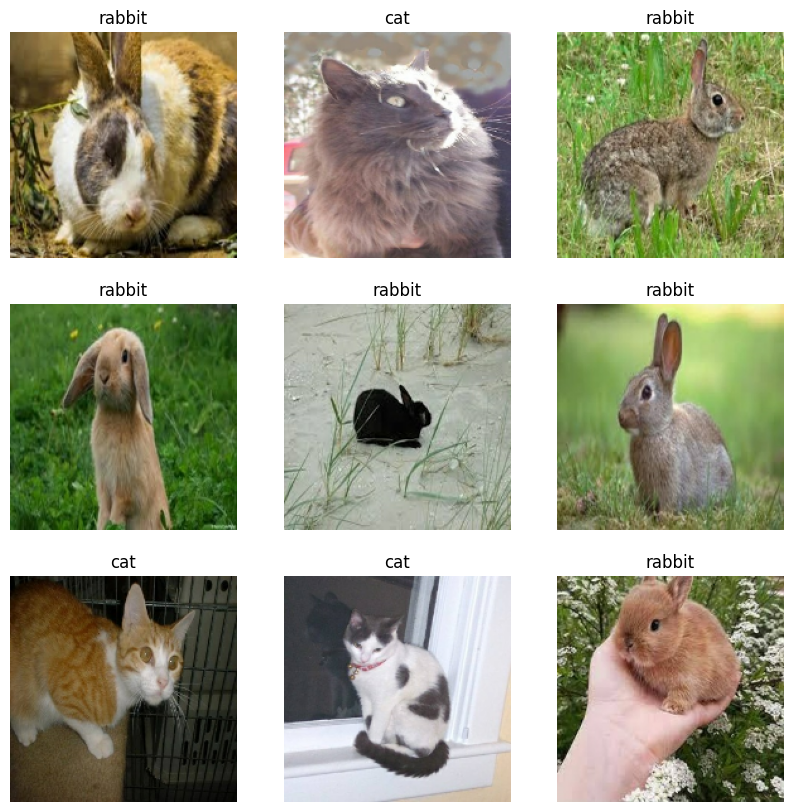

In [15]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
normalization_layer = layers.Rescaling(1./255)
print(normalization_layer)

<Rescaling name=rescaling, built=False>


In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in [0,1].
print(np.min(first_image), np.max(first_image))


0.0 0.93464065


In [23]:
num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), 
    layers.Conv2D(16, 3, padding='same', activation='relu'), 
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'), 
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'), 
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])


C:\Users\madha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,988,898 (15.22 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
epochs=5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accuracy: 0.5096 - loss: 1.0397 - val_accuracy: 0.5122 - val_loss: 0.6933
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.5719 - loss: 0.6393 - val_accuracy: 0.6585 - val_loss: 0.6173
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - accuracy: 0.7513 - loss: 0.5158 - val_accuracy: 0.5854 - val_loss: 0.6607
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.7477 - loss: 0.5146 - val_accuracy: 0.6463 - val_loss: 0.6072
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - accuracy: 0.7961 - loss: 0.3919 - val_accuracy: 0.7073 - val_loss: 0.5793


In [29]:
model_name = "cat-rabbit.h5"
model.save(model_name)
print("Saved Trained Model at %s" % model_name)

Saved Trained Model at cat-rabbit.h5


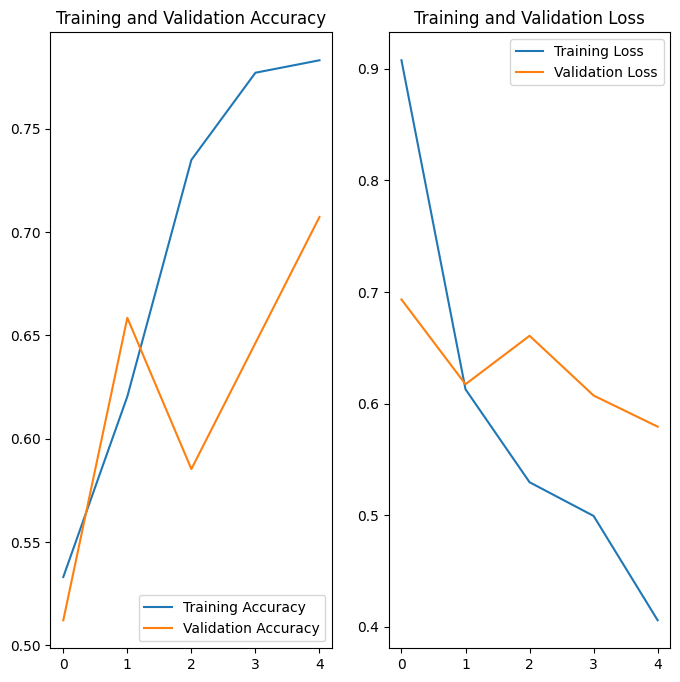

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs) 
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
print("PRE_TRAINED MODEL IS USED..!!")
model = load_model('./cat-rabbit.h5', compile= True)


PRE_TRAINED MODEL IS USED..!!


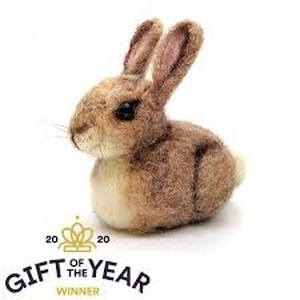

In [44]:
imageName = "./val-cat-rabbit/rabbit/rabbit.2.jpg"
PIL.Image.open(imageName)

In [45]:
img = tf.keras.utils.load_img(
    imageName, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array,0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions)
score

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.4173952, 0.5826048]], dtype=float32)>

In [46]:
print("Predicted images is :: " + class_names[np.argmax(score)])

Predicted images is :: rabbit
